In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In this blog post, I'll demonstrate how to use a custom C++ function in a [Stan](http://mc-stan.org/) model using the Python interface [PyStan](http://mc-stan.org/interfaces/pystan.html). This was previously only possible using the R interface [RStan](http://mc-stan.org/interfaces/rstan.html) (see [an example here](https://cran.r-project.org/web/packages/rstan/vignettes/external.html)) so I hacked PyStan to make this possible in Python as well. You'll need to install [the 'feature-external-c++' branch of my fork of PyStan](https://github.com/dfm/pystan/tree/feature-external-c++) to make this work. This is unlikely to get merged into PyStan because there is a hope that this will one day be a feature of the core Stan language, but if you're impatient and need this now, read on!

Since I'm an astronomer, I'll motivate this demo using a specific example from astronomy but I expect that this is more broadly applicable. The basic motivation is that I have some existing C++ code that implements my model and its derivatives so I don't want to have to re-write the model in the Stan language. Furthermore, part of the model requires solving a transcendental equation numerically; it's not obvious that applying autodiff to an iterative solver is a great idea, but the analytic gradients are trivial to evaluate.

The example that we'll use is fitting [radial velocity observations of an exoplanet](https://en.wikipedia.org/wiki/Doppler_spectroscopy). In particular, we'll fit recent observations of [51 Peg b](https://en.wikipedia.org/wiki/51_Pegasi_b), the first exoplanet discovered around a main sequence star. To start, let's run all of the imports and download the time series from the [Exoplanet Archive](http://exoplanetarchive.ipac.caltech.edu/cgi-bin/DisplayOverview/nph-DisplayOverview?objname=51+Peg+b&type=CONFIRMED_PLANET). The most recent observations are from [Howard & Fulton (2016)](https://arxiv.org/abs/1606.03134), but let's download some older data to make the comparisons easier. We'll download the data from [Butler et al. (2006)](http://adsabs.harvard.edu/abs/2006ApJ...646..505B) instead.

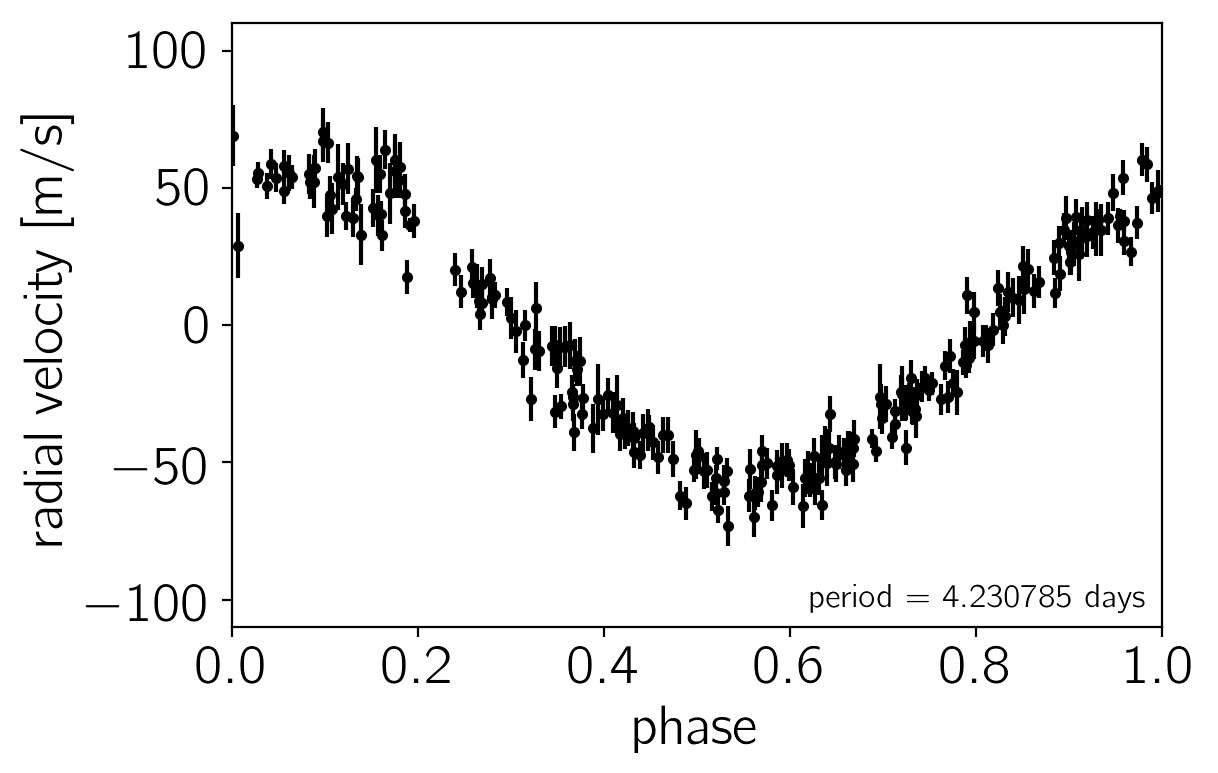

In [8]:
# First, import all the packages that we'll need:
from __future__ import division, print_function

import time
import corner  # http://corner.readthedocs.io
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This must be the 'feature-external-c++' branch of my fork:
# https://github.com/dfm/pystan/tree/feature-external-c++
import pystan

# Download the dataset from the Exoplanet Archive:
url = "https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0113/0113357/data/UID_0113357_RVC_001.tbl"
r = requests.get(url)
if r.status_code != requests.codes.ok:
    r.raise_for_status()
data = np.array([l.split() for l in r.text.splitlines()
                 if not l.startswith("\\") and not l.startswith("|")],
                dtype=float)
t, rv, rv_err = data.T
t -= np.mean(t)

# Plot the observations "folded" on the published period:
# Butler et al. (2006) https://arxiv.org/abs/astro-ph/0607493
lit_period = 4.230785
plt.errorbar((t % lit_period)/lit_period, rv, yerr=rv_err, fmt=".k", capsize=0)
plt.xlim(0, 1)
plt.ylim(-110, 110)
plt.annotate("period = {0:.6f} days".format(lit_period),
             xy=(1, 0), xycoords="axes fraction",
             xytext=(-5, 5), textcoords="offset points",
             ha="right", va="bottom", fontsize=12)
plt.ylabel("radial velocity [m/s]")
plt.xlabel("phase");

## The problem statement: a Kepler solver in C++

We want to fit this dataset using a Keplerian model where the radial velocity is given by

$$
RV(t) = RV_0 + RV_\mathrm{trend}\,t + K\,\left[\cos(\omega+f(t))+e\,\cos(\omega)\right]
$$

where $RV_0$ is the mean radial velocity, $RV_\mathrm{trend}$ is the slope of the RV trend, $K$ is the semi-amplitude, $\omega$ is the argument of periastron, and $f(t)$ is the true anomaly. I won't go into details about all of these parameters, but interested readers can check out [the discussion here](http://exoplanets.astro.yale.edu/workshop/EPRV/Bibliography_files/Radial_Velocity.pdf) or in the [Exoplanets](https://www.amazon.com/Exoplanets-Space-Science-Sara-Seager/dp/0816529450) textbook.

The crux for our discussion is that computation of $f(t)$ requires solving [Kepler's equation](https://en.wikipedia.org/wiki/Kepler%27s_equation)

$$
M(t) = E(t) - e\,\sin E(t)
$$

for the eccentric anomaly $E(t)$ at given mean anomaly $M(t)$ and eccentricity $e$. This equation is typically solved numerically using the [Newton–Raphson method](https://en.wikipedia.org/wiki/Newton%27s_method). The following is a simple implementation in C++:

```cpp
double kepler (double M, double e) {
  double E0 = M, E = M;
  for (int i = 0; i < 200; ++i) {
    double g = E0 - e * sin(E0) - M,
           gp = 1.0 - e * cos(E0);
    E = E0 - g / gp;

    // Check for convergence.
    if (abs((E - E0) / E) <= 1.234e-10) return E;
    E0 = E;
  }
  
  // If we get here, we didn't converge, but return the best estimate.
  return E;
}
```

This function could, of course, also be implemented directly in the Stan language. It is, however, standard lore that one shouldn't apply automatic differentiation to an iterative method. Furthermore, it is easy to compute the partial derivatives of this expression analytically:

$$
\frac{dE(t)}{dM(t)} = \frac{1}{1-e\,\cos E(t)}
$$

and

$$
\frac{dE(t)}{de} = \frac{\sin E(t)}{1-e\,\cos E(t)}
$$

In the following few cells, we'll implement this method with a syntax that is compatible with Stan. First, the code from above with a few extra bells and whistles:

In [3]:
cpp_code = """
inline double kepler (double M, double e, std::ostream* pstream) {
  // Check for un-physical parameters.
  if (e < 0.0 || e >= 1.0)
    domain_error("kepler", "eccentricity is", e, "");

  double E0 = M, E = M;
  for (int i = 0; i < 200; ++i) {
    double g = E0 - e * sin(E0) - M,
           gp = 1.0 - e * cos(E0);
    E = E0 - g / gp;

    // Check for convergence.
    if (abs((E - E0) / E) <= 1.234e-10) return E;

    E0 = E;
  }
  
  // If we get here, we didn't converge, but return the best estimate.
  return E;
}
"""

The main difference between this implementation and the one above is that the function takes an extra `std::ostream*` argument. This stream can be used for logging if your method needs to print anything to the terminal and any function that you expose to Stan *must* have this as the last argument. This function also checks for the allowed domain (0 to 1) for the eccentricity and it will throw an error (and set the probability of the model to zero) if the eccentricity is outside of this allowed range.

Next, we must implement the derivatives of this function using overloading with the `stan::math::var` type. This is the type that is used by Stan to compute derivatives in their automatic differentiation library (see [Carpenter et al. (2015)](https://arxiv.org/abs/1509.07164) for details) and I've found that the easiest way to use them is with the `precomp_v_vari` and `precomp_vv_vari` wrapper classes. For example, to provide the derivatives with respect to both $M(t)$ and $e$, we will use the following code:

In [4]:
cpp_code += """
inline var kepler (const var& M_var, const var& e_var, std::ostream* pstream) {
  // First, compute the value of E at the current values of M and e
  double M = M_var.val(),
         e = e_var.val(),
         E = kepler(M, e, pstream);

  // Then compute the partial derivatives:
  double dE_dM = 1.0 / (1.0 - e * cos(E)),
         dE_de = sin(E) * dE_dM;
         
  // Construct the autodiff wrapper:
  return var(new precomp_vv_vari(
    E,             // The _value_ of the output
    M_var.vi_,     // The input gradient wrt M
    e_var.vi_,     // The input gradient wrt e
    dE_dM,         // The partial introduced by this function wrt M
    dE_de          // The partial introduced by this function wrt e
  ));
}

"""

We now go on to implement versions of this function for fixed $M(t)$ and $e$. I don't *think* that these extra functions are strictly needed in our case because $M(t)$ and $e$ will always be functions of parameters, but it doesn't hurt to implement all of the permutations in case we decide to fix any parameters. In these cases, we use the `precomp_v_vari` class because the derivatives are only taken with repect to a single parameter:

In [5]:
cpp_code += """
inline var kepler (double M, const var& e_var, std::ostream* pstream) {
  double e = e_var.val(),
         E = kepler(M, e, pstream),
         dE_de = sin(E) / (1.0 - e * cos(E));
  return var(new precomp_v_vari(E, e_var.vi_, dE_de));
}

inline var kepler (const var& M_var, double e, std::ostream* pstream) {
  double M = M_var.val(),
         E = kepler(M, e, pstream),
         dE_dM = 1.0 / (1.0 - e * cos(E));
  return var(new precomp_v_vari(E, M_var.vi_, dE_dM));
}

"""

Finally, we'll save this to a C++ header file in the current directory:

In [6]:
with open("kepler.hpp", "w") as f:
    f.write(cpp_code)

## The Stan model

Now, let's build our model in Stan. Describing the Stan language is beyond the scope of this post so you should check out [the official docs](http://mc-stan.org/documentation/) if you're new to Stan. The only non-standard addition in our model is a `functions` block at the beginning with the interface for our Kepler solver:

```
functions {
    real kepler(real M, real e);
}
```

After the `functions` block, the rest of the model is pretty standard. I found that the sampling performance was substantially improved after reparameterizing the model a bit. The first crucial reaparameterization is to sample in $\sqrt{e}\,\sin\omega$ and $\sqrt{e}\,\cos\omega$ instead of $e$ and $\omega$. For $e \le 1$, this still has a uniform prior distribution for $e$ and $\omega$, but the shape posterior in these coordinates is much better behaved. The second reparameterization is to sample in $\phi = \frac{2\,\pi\,t_0}{P} - \omega$ instead of $t_0$.

The following cell defines the full probabilistic model in the Stan language and compiles the generated C++ code including the `kepler.hpp` header that we defined above. Note the `allow_undefined`, `includes`, and `include_dirs` arguments in the `pystan.StanModel` constructor. These are required to allow interfacing to external C++ code, but they're not provided by the official PyStan implementation so, as mentioned above, you'll need to have my fork of PyStan installed to compile this model.

In [7]:
model_code = """
functions {
    real kepler(real M, real e);
}
data {
    int<lower=0> N;          // number of times
    vector[N]    t;          // the times
    vector[N]    rv;         // the rvs
    vector[N]    rv_err;     // the rv uncertainties
    int<lower=0> N_pred;     // number of predictions
}
parameters {
    real<lower=0, upper=log(200)> log_K;       // ln(semi-amplitude)
    real<lower=0, upper=log(100)> log_P;       // ln(period)
    real<lower=0, upper=2*pi()>   phi;         // phase
    real<lower=-1, upper=1>       sqrte_sinw;  // sqrt(e)*sin(w)
    real<lower=-1, upper=1>       sqrte_cosw;  // sqrt(e)*cos(w)
    real<lower=-10, upper=5>      log_jitter;  // ln(jitter)
    real<lower=-10, upper=10>     rv0;         // mean RV
    real<lower=-10, upper=10>     rv_trend;    // RV trend
}
transformed parameters {
    real n       = 2*pi()*exp(-log_P);
    real e       = sqrte_sinw^2 + sqrte_cosw^2;
    real K       = exp(log_K);
    real cosw    = sqrte_cosw / sqrt(e);
    real sinw    = sqrte_sinw / sqrt(e);
    real w       = atan2(sinw, cosw);
    real jitter2 = exp(2*log_jitter);
    real t0      = (phi + w) / n;
    
    // This will store the predicted RV signal at the observed times
    vector[N] mod;
    
    // And this stores the RV trend at the observed times
    vector[N] trend;
    
    for (j in 1:N) {
        // Compute the predicted RV signal at time t[j]
        real M = n * t[j] - (phi + w);
        real E = kepler(M, e);
        real f = 2*atan2(sqrt(1+e) * tan(0.5*E), sqrt(1-e));
        trend[j] = rv0 + rv_trend * t[j] / 365.25;
        mod[j] = trend[j] + K * (cosw*cos(f)-sinw*sin(f)+e*cosw);
    }
}
model {
    // We already have a uniform prior on "e" but it must be in the
    // range [0, 1].
    e ~ uniform(0, 1);
    
    // Loop over observations
    for (j in 1:N) {
        // Compute the predicted RV signal at time t[j]
        // Assume Gaussian uncertainties with jitter
        rv[j] ~ normal(mod[j], sqrt(rv_err[j]^2 + jitter2));
    }
}
generated quantities {
    // At each accepted step in the MCMC, compute the predicted RV
    // curve for `N_pred` equally-spaced phases
    vector[N_pred] rv_pred;
    for (j in 1:N_pred) {
        real M = (2.0*pi()*(j-1))/(N_pred-1) - (phi + w);
        real E = kepler(M, e);
        real f = 2*atan2(sqrt(1+e) * tan(0.5*E), sqrt(1-e));
        rv_pred[j] = K * (cosw*cos(f)-sinw*sin(f)+e*cosw);
    }
}
"""

strt = time.time()
model = pystan.StanModel(model_code=model_code, allow_undefined=True,
                         includes=["kepler.hpp"], include_dirs=["."])
print("Compilation took {0:.1f} seconds".format(time.time() - strt))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c5f5c1872e446516bc7c7ef1315d3de8 NOW.


Compilation took 50.2 seconds


## Inference & parameter estimation

To start, we need to initialize the parameters of our model. In this case, it would be pretty inefficient to optimize with random restarts within the prior because some of the parameters are very well constrained (e.g. period) and we probably already have a good initial guess for the values of these parameters. Instead, we will use a custom initialization function and the `L-BFGS` implementation built into Stan to find the maximum *a postieriori* (MAP) parameters.

In [9]:
np.random.seed(42)

# Custom initialization function. Some parameters are randomized
def init_func():
    e = np.random.uniform(0, 0.01)
    omega = np.random.uniform(0, 2*np.pi)
    return dict(
        log_K=np.log(0.5 * (np.max(rv) - np.min(rv))),
        log_P=np.log(4.230785),
        phi=np.random.uniform(0, 2*np.pi),
        sqrte_sinw=np.sqrt(e)*np.sin(omega),
        sqrte_cosw=np.sqrt(e)*np.cos(omega),
        log_jitter=np.log(np.mean(rv_err)),
        rv0=np.mean(rv),
        rv_trend=0.0,
    )

# Run 5 randomized restarts to find the MAP parameters
data = dict(N=len(t), t=t, rv=rv, rv_err=rv_err, N_pred=100)
best = dict(value=-np.inf)
for k in range(5):
    try:
        opt = model.optimizing(data=data, as_vector=False, init=init_func)
    except RuntimeError:
        continue
    if opt["value"] > best["value"]:
        best = opt
        
print("Maximum log-probability: {0:.3f}".format(best["value"]))

Maximum log-probability: -602.641


To make sure that we're not totally off to start, let's plot the prediction of the model at the MAP.

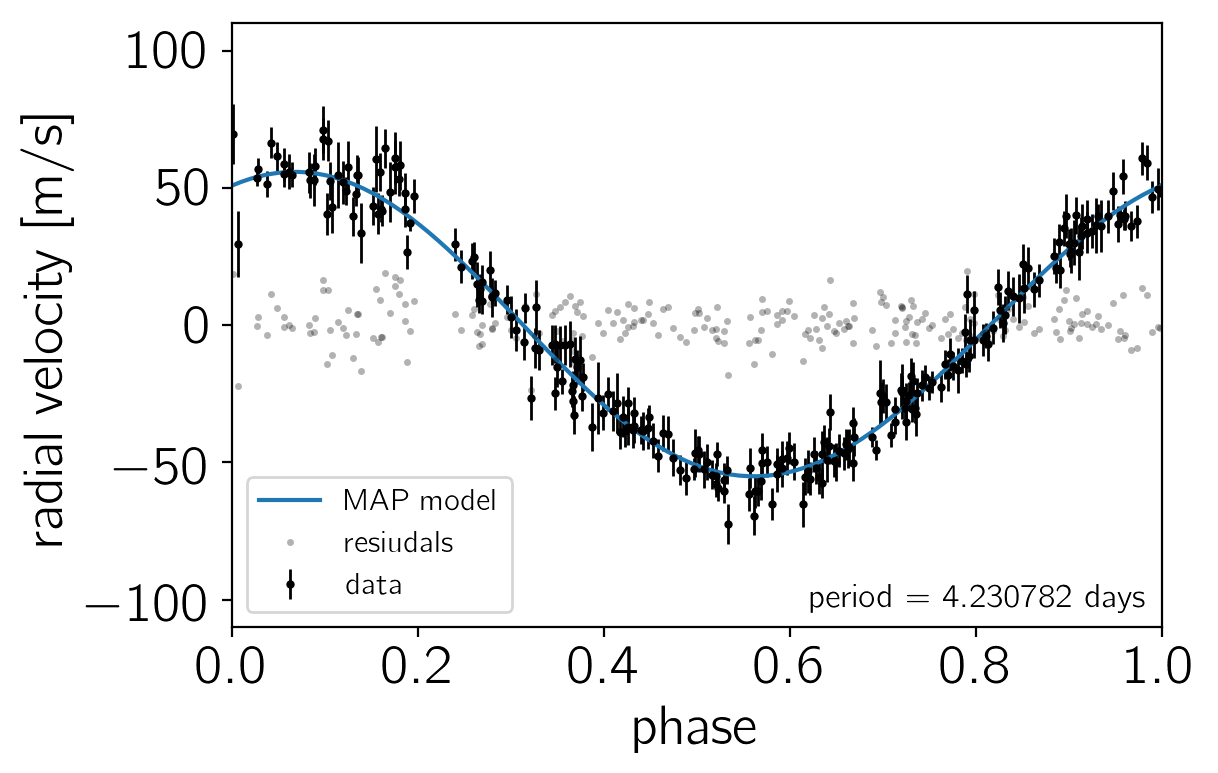

In [10]:
# Extract the best fit parameters
period = np.exp(best["par"]["log_P"])
t0 = best["par"]["t0"]
pred = best["par"]["rv_pred"]
mod = best["par"]["mod"]
trend = best["par"]["trend"]

# Compute the effective uncertainties including the contribution
# of jitter
yerr = np.sqrt(rv_err**2 + np.exp(2*best["par"]["log_jitter"]))

# Plot the data, model, and residuals
plt.errorbar((t/period) % 1.0, rv - trend, yerr=yerr, fmt=".k", label="data", lw=1, ms=4)
plt.plot(np.arange(len(pred)) / (len(pred)-1), pred, label="MAP model")
plt.plot((t/period) % 1.0, rv - mod, ".k", alpha=0.3, mec="none",
         label="resiudals", ms=5)

plt.legend(loc=3, fontsize=11)
plt.xlim(0, 1)
plt.ylim(-110, 110)
plt.annotate("period = {0:.6f} days".format(period),
             xy=(1, 0), xycoords="axes fraction",
             xytext=(-5, 5), textcoords="offset points",
             ha="right", va="bottom", fontsize=12)
plt.ylabel("radial velocity [m/s]")
plt.xlabel("phase");

Now, starting from the MAP coordinates, we'll run 4 parallel MCMC chains of 2000 steps using the default settings in Stan. By default, Stan discards 50% of the chain as "warmup" so we'll end up with 4000 samples (1000 from each chain).

In [12]:
strt = time.time()
fit = model.sampling(iter=2000, data=data, init=lambda *args: best["par"])
print("Sampling took {0:.1f} seconds".format(time.time() - strt))

Sampling took 542.2 seconds


PyStan doesn't really provide a very flexible interface for looking at convergence diagnostics of the MCMC chains and if we use the default method, the output would be longer than this whole blog post! So the following cell hacks the standard diagnostics output to only show the first couple of lines. This is enough for us to get a sense for how things went.

In [17]:
lines = fit.__str__().splitlines()
print("\n".join(lines[:21] + lines[-5:]))

Inference for Stan model: anon_model_c5f5c1872e446516bc7c7ef1315d3de8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
log_K         4.02  1.7e-4 9.3e-3    4.0   4.01   4.02   4.03   4.04   3002    1.0
log_P         1.44  1.4e-7 9.0e-6   1.44   1.44   1.44   1.44   1.44   4000    nan
phi            0.4  1.9e-4 9.8e-3   0.38   0.39    0.4    0.4   0.42   2776    1.0
sqrte_sinw    0.04  1.4e-3   0.06  -0.08-1.4e-3   0.05   0.09   0.15   1944    1.0
sqrte_cosw    0.03  1.4e-3   0.06  -0.09  -0.01   0.04   0.08   0.14   2056    1.0
log_jitter   -4.53     0.1   3.11  -9.74  -7.27  -4.47  -1.79   0.47    973    1.0
rv0          -1.83  7.5e-3   0.38  -2.55   -2.1  -1.83  -1.57  -1.08   2655    1.0
rv_trend     -1.59  3.6e-3   0.19  -1.96  -1.73  -1.59  -1.47  -1.21   2846    1.0
n             1.49  2.1e-7 1.3e-5   1.49   1.49   1.49   1.49   

From this, we can see that the sampling for most of the parameters has converged. I think that the `Rhat = nan` for the log period is OK and it has something to do with the precision with which `Rhat` is computed compared to the fractional posterior uncertainty on the period.

Now, let's make some plots of our results. First, let's make a [corner plot](http://corner.readthedocs.io/) of the posterior samples.

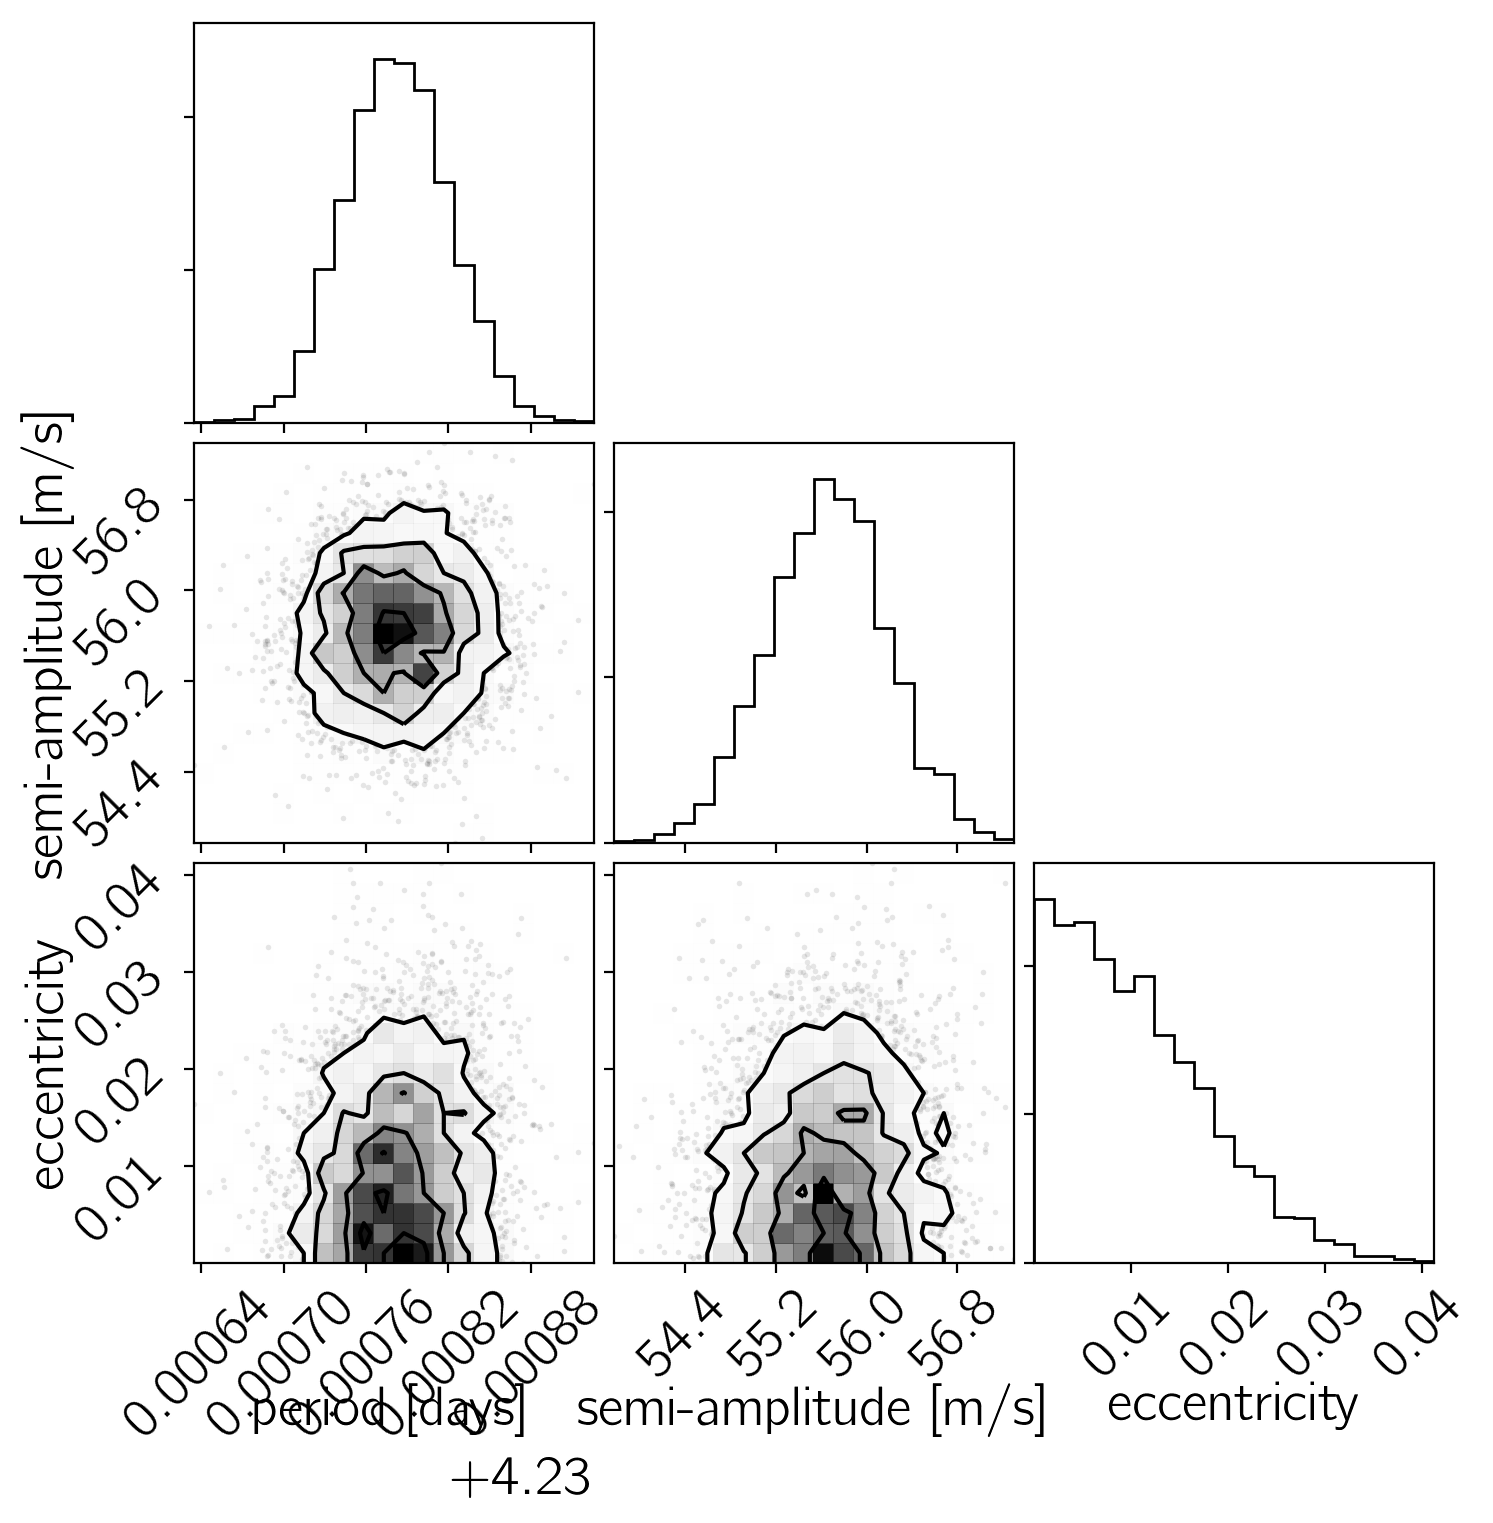

In [14]:
params = ["log_P", "K", "e"]
samples = pd.DataFrame(fit.extract(permuted=True, pars=params))
samples["period"] = np.exp(samples["log_P"])
samples = np.array(samples[["period", "K", "e"]])
labels = ["period [days]", "semi-amplitude [m/s]", "eccentricity"]
corner.corner(samples, labels=labels);

Another good plot is the posterior model predictions overplotted on the data. In the following figure, the green "line" is actually a *contour* showing the 68% credible region for the model RV as a function of phase.

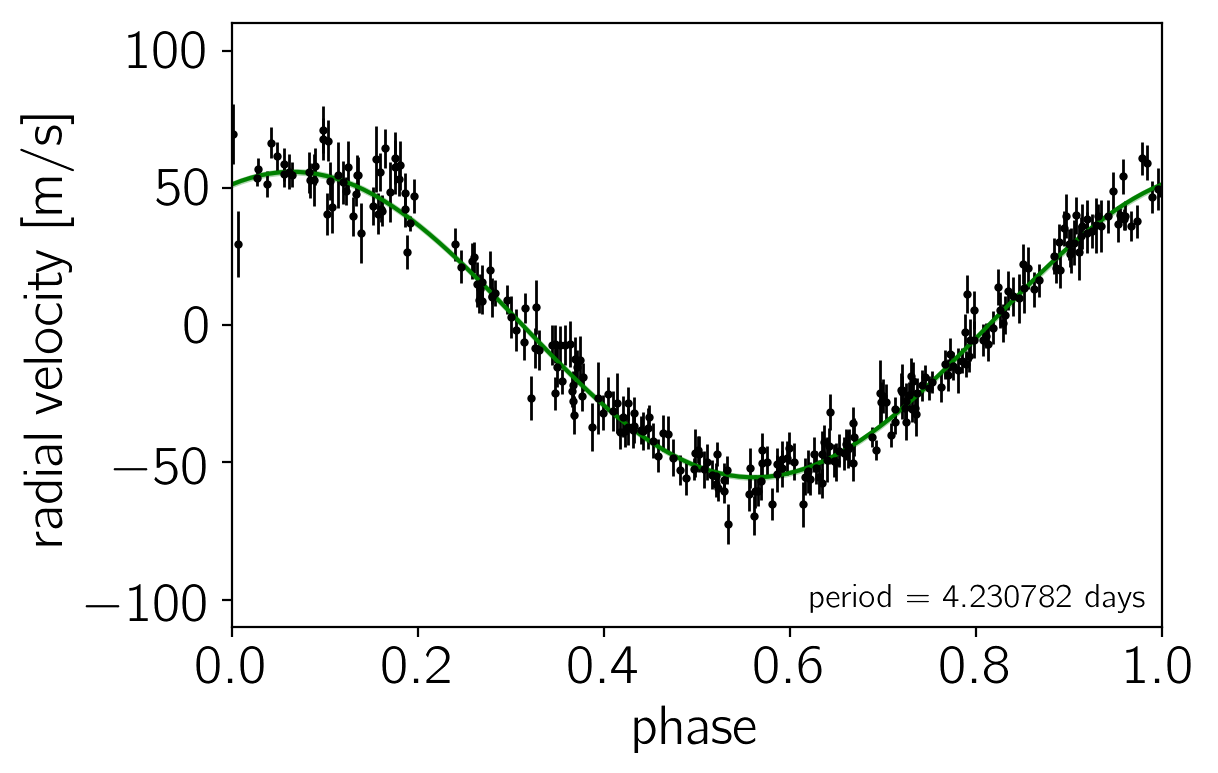

In [15]:
samples = fit.extract(permuted=True)
pred = samples["rv_pred"]
phase = np.arange(pred.shape[1]) / (pred.shape[1]-1)

q = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(phase, q[1], color="g")
plt.fill_between(phase, q[0], q[2], color="g", alpha=0.3)
period = np.exp(best["par"]["log_P"])
plt.errorbar((t/period) % 1.0, rv - trend, yerr=yerr, fmt=".k", label="data", lw=1, ms=4)
plt.xlim(0, 1)
plt.ylim(-110, 110)
plt.annotate("period = {0:.6f} days".format(period),
             xy=(1, 0), xycoords="axes fraction",
             xytext=(-5, 5), textcoords="offset points",
             ha="right", va="bottom", fontsize=12)
plt.ylabel("radial velocity [m/s]")
plt.xlabel("phase");

## Results & summary

Now that we have a sufficiently converged MCMC chain, we can compare our results to the literature values. In particular, let's look at the measured period and semi-amplitude. The literature values of these properties are ([Butler et al. 2006](http://adsabs.harvard.edu/abs/2006ApJ...646..505B)):

$$
P = 4.230785 \pm 0.000036\,\mathrm{days} \quad \mathrm{and} \quad K = 55.94 \pm 0.69\,\mathrm{m/s}
$$

The constraints that we get based on our MCMC chains are:

In [18]:
periods = np.exp(samples["log_P"])
print("P = {0:.6f} ± {1:.6f}".format(np.mean(periods),  np.std(periods)))
amps = np.exp(samples["log_K"])
print("K = {0:.2f} ± {1:.2f}".format(np.mean(amps),  np.std(amps)))

P = 4.230783 ± 0.000038
K = 55.65 ± 0.52


These results are in good agreement with the published values based on the same dataset. The error bars on the semi-amplitude are somewhat smaller based on our analysis, but I haven't had a chance to track down exactly why that might be and it's probably beyond the scope of this post.

The fact that we get consistent results does indicate that this method is working, but the real point of this blog post was to demonstrate how to use external C++ functions for MCMC sampling with PyStan. I imagine this feature being useful in a few situations and the lack of this feature was the main reason why I've been hesitant to use Stan in the past. The two main use cases that I see are:

1. I have a full model implemented in C or C++ already and I don't want to reimplement the code in the Stan language, and
2. I have a component of the model that requires special functions or some sort of numerical solution that isn't implemented in the core Stan language, but I can compute the gradients analytically.

I certainly have problems in my own research that have this structre and I hope that this discussion will be useful for others in the same situation.

## Postscript: Using Stan autodiff in the external function

In the previous discussion, we assumed that you could easily compute the gradient of your external C++ function. I expect that this will probably be the most common situation because you could probably write your function in Stan directly instead of C++ if that's not what you want. But, for completeness, I wanted to include a demonstration of how you can use Stan's autodiff library to compute the gradients of your function automatically. Here's how we would update our example from above to use autodiff instead of analytic gradients:

In [20]:
with open("kepler_autodiff.hpp", "w") as f:
    f.write("""
template <typename T1, typename T2>
typename boost::math::tools::promote_args<T1, T2>::type
kepler (const T1& M, const T2& e, std::ostream* pstream) {
  typedef typename boost::math::tools::promote_args<T1, T2>::type T;

  // Check for un-physical parameters.
  if (e < T2(0.0) || e >= T2(1.0))
    domain_error("kepler", "eccentricity is", e, "");

  T E0 = M, E = M;
  for (int i = 0; i < 200; ++i) {
    T g = E0 - e * sin(E0) - M,
      gp = T(1.0) - e * cos(E0);
    E = E0 - g / gp;

    // Check for convergence.
    if (abs((E - E0) / E) <= 1.234e-10) return E;

    E0 = E;
  }
  
  // If we get here, we didn't converge, but return the best estimate.
  return E;
}

""")
    
model_autodiff = pystan.StanModel(model_code=model_code, allow_undefined=True,
                                  includes=["kepler_autodiff.hpp"],
                                  include_dirs=["."])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c5f5c1872e446516bc7c7ef1315d3de8 NOW.
